# BindingDB overview

## Setup

Add user's current working directory to search path:

In [1]:
import sys
sys.path = [r"C:\sw\plb"] + sys.path

Also change current working directory:

In [2]:
import os
os.chdir(r"C:\sw\plb")

Imports:

In [3]:
from collections import Counter
from pathlib import Path

import myst_nb

from src.config import get_config
from src.data.bindingdb.io import read_bdb_single_chain
from src.data_structure_utils import read_tsv
from src.stats_utils import (
    get_stats_from_counter,
    print_counter_stats_df,
    print_raw_ligand_smiles_stats,
    print_raw_protein_seq_stats,
)

Set up document options:

In [4]:
# This import automatically sets seeds
import src.set_seed

# Nice pandas tables
import itables
itables.init_notebook_mode(all_interactive=True)
itables.options.maxColumns = 0  # unlimited columns
itables.options.maxBytes = 32000000
itables.options.classes = ["display", "nowrap"]
itables.options.order = [] # disable auto-sorting

<IPython.core.display.Javascript object>

Get filepaths of data directories:

In [5]:
config = get_config()
dir_data = Path(config["data_directory"])
dir_features = Path(config["features_directory"])

## Displaying some sample data

BindingDB has experimentally measured binding dissociation constants (Kd and Ki)
for a variety of protein-ligand pairs.

Load processed BindingDB dataframe:

In [6]:
df_bdb = read_bdb_single_chain(
    dir_data / "bindingdb/dataframes_filtered/single_chain.tsv"
)

Print a few sample rows from the dataframe. Firstly truncate some of the long
columns to make things easier to read. Also note that the BindingDB URLs don't
seem to work anymore (I think they've updated their website recently):

In [7]:
df_bdb_trunc = df_bdb.copy()
df_bdb_trunc["bdb_ligand_name"] = df_bdb_trunc["bdb_ligand_name"].str[:50]
df_bdb_trunc["authors"] = df_bdb_trunc["authors"].str[:50]
df_bdb_trunc["ligand_raw_inchi"] = df_bdb_trunc["ligand_raw_inchi"].str[:50]
df_bdb_trunc["pdb_id_85_pct_similarity"] = df_bdb_trunc["pdb_id_85_pct_similarity"].str[:50]
df_bdb_trunc["chain_sequence"] = df_bdb_trunc["chain_sequence"].str[:50]
itables.show(df_bdb_trunc.sample(50))

Loading... (need help?)


The dataframe has these columns:

In [8]:
itables.show(DataFrame({"column_name": df_bdb.columns}))

Loading... (need help?)


I've described a few of the important columns below.

- `ligand_raw_smiles` is the SMILES string provided by BindingDB;
  `ligand_rdkit_smiles` is the SMILES string after being canonicalised by the
  rdkit package
- `kd_nM_value` is the binding dissociation constant, in units of nM
- `chain_sequence` is the protein's amino acid sequence. There's no information
  provided on post-translational modifications, crosslinks, or prosthetic
  groups, etc.
- `chain_swissprot_primary_id` is the protein's UniProt id


## Filtering

In [9]:
# Get variables from config file for the following section

min_aa = config["protein_chain_min_aa_length"]
myst_nb.glue("min_aa", min_aa)

max_aa = config["protein_chain_max_aa_length"]
myst_nb.glue("max_aa", max_aa)

lig_allowed_el = config["ligand_allowed_elements"]
myst_nb.glue("lig_allowed_el", lig_allowed_el)

min_atoms = config["ligand_min_number_of_non_hydrogen_atoms_allowed"]
myst_nb.glue("min_atoms", min_atoms)

max_atoms = config["ligand_max_number_of_non_hydrogen_atoms_allowed"]
myst_nb.glue("max_atoms", max_atoms)

10

1500

['H', 'B', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I']

5

1000

The dataframe displayed above has been heavily filtered. The filtering steps I
performed are:

- Removed entries with missing data
- Removed entries with unusual pH or temperature values
- Removed entries with missing UniProt ids
- Filtered to keep only entries with protein chains satisfying {glue:}`min_aa` <
  length < {glue:}`max_aa`
- Removed entries with unusual amino acids (e.g. selenocysteine) or unknown
  amino acids (`X` symbol)
- Filtered to keep only entries with Kd or Ki values listed (i.e. no IC50 or EC50)
- Removed entries where rdkit couldn't parse the SMILES string
- Filtered to keep only entries with ligands that have elements in the following list:

In [10]:
config["ligand_allowed_elements"]

['H', 'B', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I']

- Filtered to keep only entries where the ligands have between {glue:}`min_atoms` and
  {glue:}`max_atoms` atoms (ignoring suppressed hydrogens)
- Removed entries where the ligand has ambiguous stereochemistry
- Removed entries where multiple protein chains are listed
- Removed entries where UniProt says that the protein is known to form protein complexes

```{note}
I'm not sure how to handle entries where the protein may have additional prosthetic groups? Ideally the prosthetic group would be counted as the "ligand", but I suspect there could be entries that have:
- a protein chain
- a listed ligand
- one or more unlisted prosthetic groups that the protein requires in order to function
```

## Data statistics

### Overall

The total number of entries (after filtering) is:

In [11]:
len(df_bdb)

99367

### Proteins

Here are some statistics on the proteins present in BindingDB.

Total number of entries: 99367
Total number of unique entries: 947
Distribution of frequencies of individual entries, linear scale (left):
Distribution of frequencies of individual entries, log scale (right):


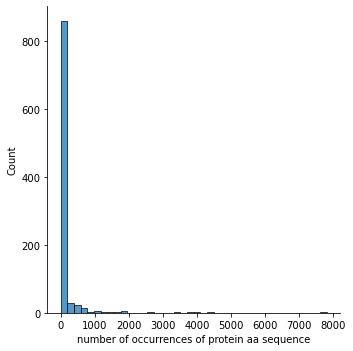

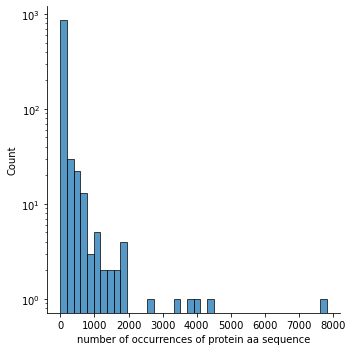

In [12]:
protein_stats = print_raw_protein_seq_stats(df_bdb)

The most commonly occurring entries are:

In [13]:
print_counter_stats_df(protein_stats)

Loading... (need help?)


### Ligands

Here are some statistics on the ligands present in BindingDB.

Total number of entries: 99367
Total number of unique entries: 57960
Distribution of frequencies of individual entries, linear scale (left):
Distribution of frequencies of individual entries, log scale (right):


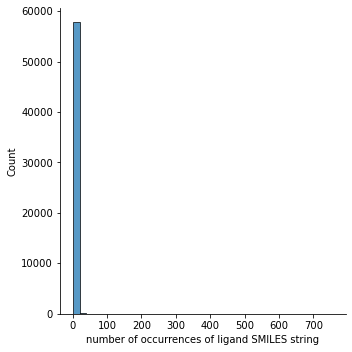

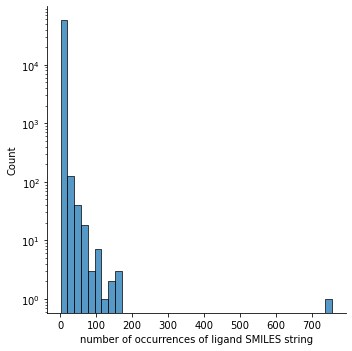

In [14]:
ligand_stats = print_raw_ligand_smiles_stats(df_bdb)

The most commonly occurring entries are:

In [15]:
print_counter_stats_df(ligand_stats)

Loading... (need help?)
